# Diffusion model

In [10]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import pathlib
from pathlib import Path

from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.utils import save_image
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar, LearningRateMonitor

import pmldiku
from pmldiku import data, model_utils, diffusion, diffusion_utils, output_utils

from typing import Any

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.diffusion, pmldiku.diffusion_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
torch.manual_seed(1)

cuda = True
batch_size = 128
epochs = 20
device_name = "cuda" if cuda else "cpu"
unet = True

device = torch.device(device_name)
kwargs = {'num_workers': 4, 'pin_memory': device} 

n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
config = diffusion.ParamConfig(n_steps, min_beta, max_beta)

code_path = Path(os.getcwd()).parent.parent

In [12]:
#mu_, std_ = 0.5, 0.5
mu_, std_ = 0.1319, 0.3094 #empircal mean and std of the full sample

transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - mu_) * (1 / std_))]
)

loader = data.load_mnist(train=True, trans=transform).setup_data_loader(batch_size=batch_size, **kwargs)

In [13]:
#batch = next(iter(loader))
#x, y = batch
#x.mean(), x.std()

In [14]:
# Construct model from params

network = diffusion.UNet if unet else diffusion.ConvNet  

model = diffusion.LightningDiffusion(
    config=config, network = network, verbose=True
)

In [15]:
cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_loss, cb_lr_monitor = (
    ModelCheckpoint(), EarlyStopping('mse_metric'), 
    TQDMProgressBar(), diffusion_utils.DiffusionLossCallback(), LearningRateMonitor('step'))  

callbacks = [cb_model_checkpoint, cb_early_stopping, cb_progress_bar, cb_loss, cb_lr_monitor]

trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device_name, callbacks=callbacks, auto_lr_find=True)
trainer.fit(model=model, train_dataloaders=loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/pcv439/miniconda3/envs/pml/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name             | Type            | Params
-----------------------------------------------------
0 | diffusion_params | DiffusionParams | 0     
1 | network          | UNet            | 606 K 
2 | diffusion        | Diffusion       | 606 K 
-----------------------------------------------------
506 K     Trainable params
100 K     Non-trainable params
606 K     Total params
2.427     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Setting diffusion params to: cuda:0
New Epoch. Loss: 0.07556986808776855
New Epoch. Loss: 0.056698285043239594
New Epoch. Loss: 0.050001129508018494
New Epoch. Loss: 0.05015254020690918
New Epoch. Loss: 0.04448067396879196
New Epoch. Loss: 0.04304816201329231
New Epoch. Loss: 0.04374014958739281
New Epoch. Loss: 0.04333217442035675
New Epoch. Loss: 0.04159603640437126
New Epoch. Loss: 0.03993668034672737
New Epoch. Loss: 0.0414712093770504
New Epoch. Loss: 0.039554666727781296
New Epoch. Loss: 0.039432913064956665
New Epoch. Loss: 0.03974977880716324
New Epoch. Loss: 0.0387999601662159
New Epoch. Loss: 0.03796374052762985
New Epoch. Loss: 0.03805195912718773
New Epoch. Loss: 0.03801847994327545


## Plot

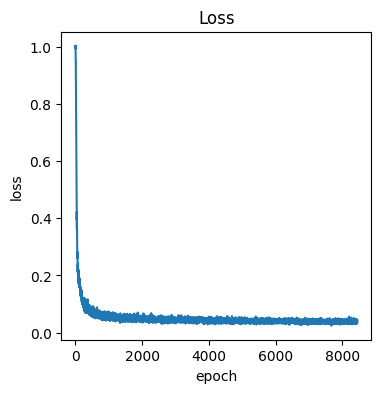

In [16]:
losses = np.array(cb_loss.train_loss)
model_utils.plot_loss(losses)



In [17]:

ims = model.to(device).generate(10000)

lars
t = 950
t = 900
t = 850
t = 800
t = 750
t = 700
t = 650
t = 600
t = 550
t = 500
t = 450
t = 400
t = 350
t = 300
t = 250
t = 200
t = 150
t = 100
t = 50
t = 0


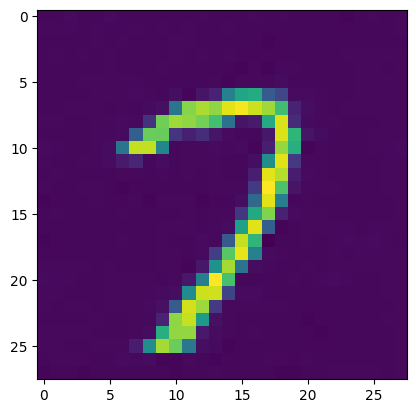

In [18]:
plt.imshow(ims[4].detach().cpu().squeeze().numpy())

In [19]:
p = os.getcwd()
tensor_path = pathlib.Path(p).parent.parent / pathlib.Path('output/image-tensors') 

standardized_ims = ((ims - ims.mean()) / ims.std()).cpu()
model_utils.save_image_tensor(standardized_ims, tensor_path, 'unet_diffusion.pkl')

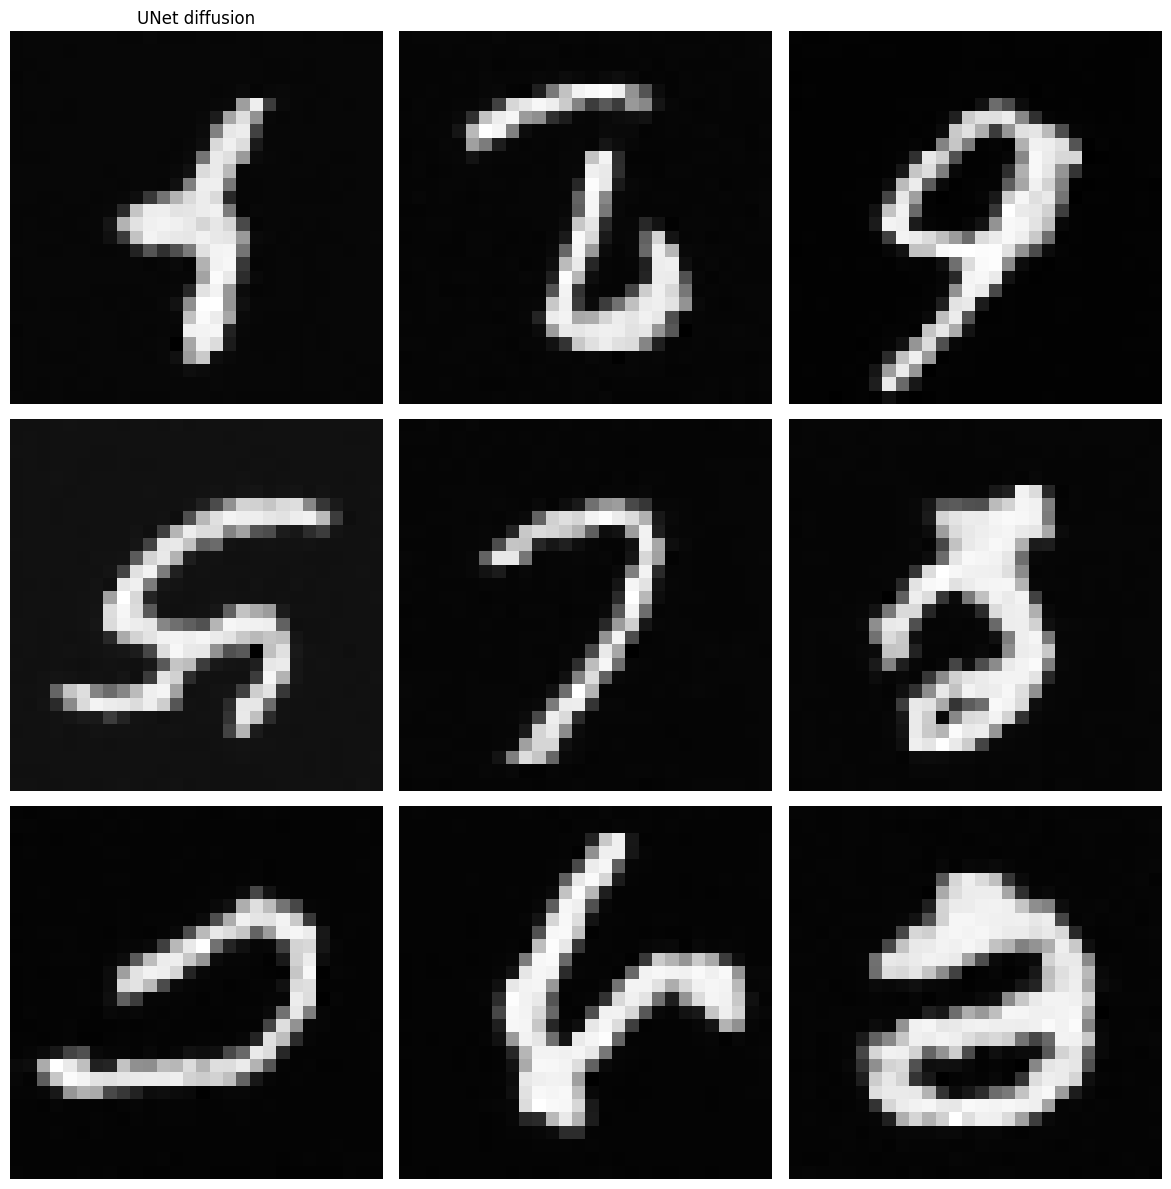

In [20]:
fig = model_utils.plot_image_reconstruction(ims[0:9].cpu().detach().numpy().reshape(9, 28, 28), num_cols=3, slim=0, title='UNet diffusion', multi_title=False)

figs_path = code_path / Path('figs')
output_utils.save_fig(fig, figs_path, 'unet-reconstruction')


In [21]:
standardized_ims = ((ims - ims.mean()) / ims.std())

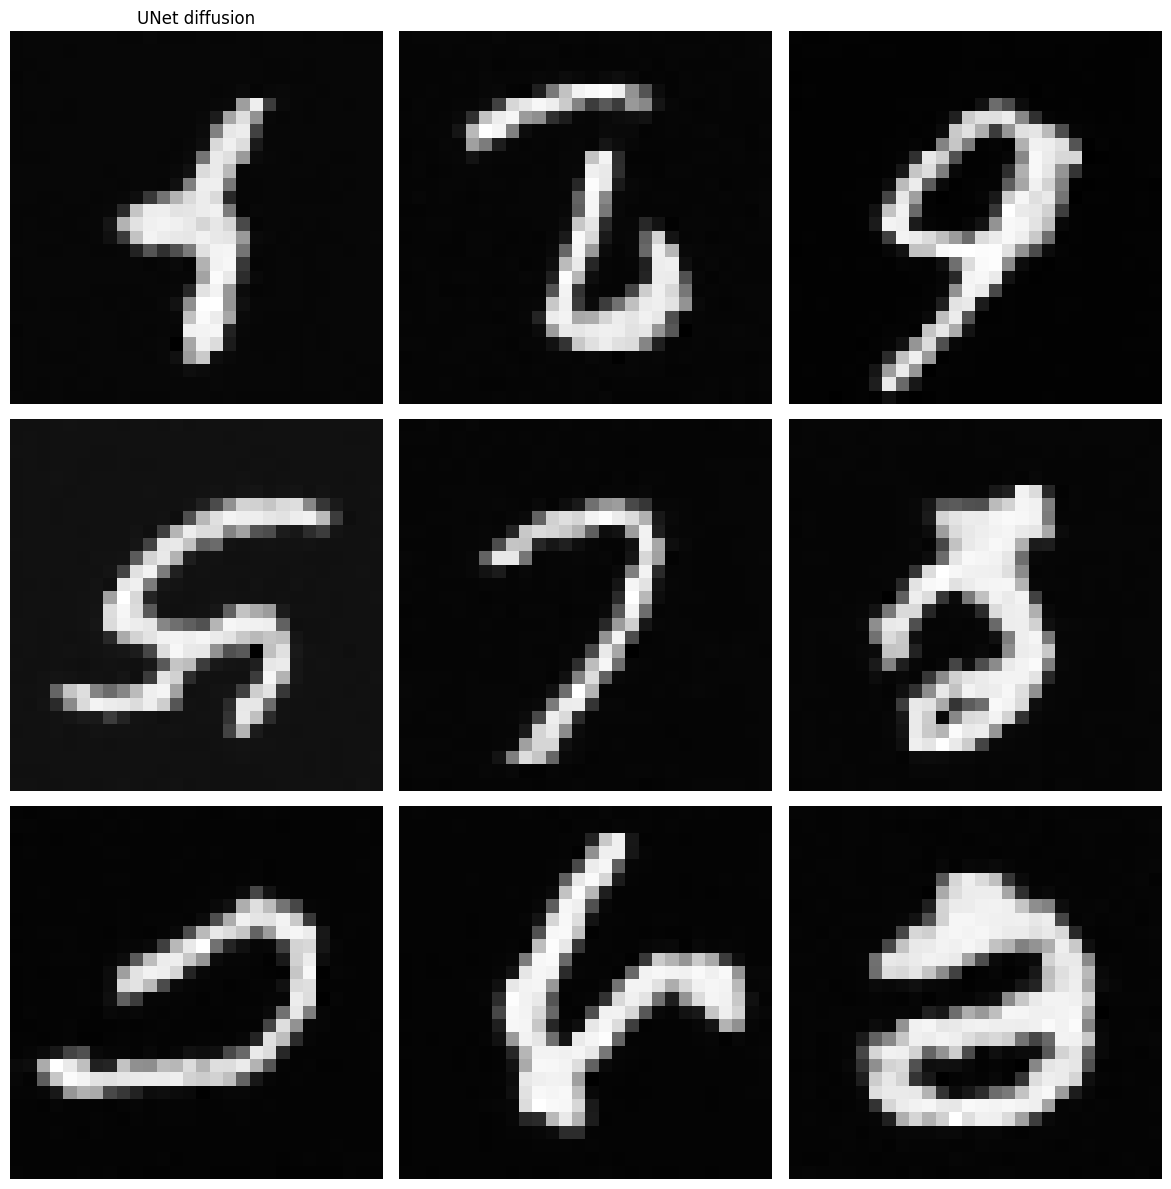

In [22]:
fig = model_utils.plot_image_reconstruction(standardized_ims[0:9].cpu().detach().numpy().reshape(9, 28, 28), num_cols=3, slim=0, title='UNet diffusion', multi_title=False)


In [24]:
fig
plt.show()